In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pims
import trackpy as tp
from scipy.interpolate import griddata

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
from utils.utils import argnotnan, set_spines_visible, generate_video_with_text, create_scalarmappable

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]


xmin, xmax = 50, 1800
ymin, ymax = 40, 1040
bbox = [xmin, xmax, ymin, ymax]

In [3]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0408_074105_019.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

# Scale D-mid
pixel_per_real_width = .75
mpp = 1.333  # microns_per_pixel
print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

# PIMs load in
EXPORT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
extract_frames_from_video(vid_path, vid_filename, frames_filepaths) if EXPORT_FRAMES else None

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), bbox))
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

# Save figures
results_path = "./data/results/vortex/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)
fig_params = {"dpi" : 600, "bbox_inches" : "tight", "edgecolor" : None}

# AX params
xy_real_step = 300
xy_px_step = xy_real_step * mpp 
ax_params = {
    "xticks" : np.arange(0,img_width, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp), xy_real_step, dtype=int),
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}

# Time vector
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
#ttrigger = 0  # previously 10 seconds > first 600 frames only...
#time_idx = np.where(time >= ttrigger)[0][0]
#ttime = time[:time_idx]
num_frames = len(time) # time_idx

print("selected time num_frames=", num_frames)#, "trigger time start-end", np.round(ttime[0]), np.round(ttime[-1]),"\n all frames", frames)

vid properties:  (60, 3311, 1920, 1080)
D MID - FHD, pixel_per_real_width =  0.75
real width (µm):  1312.83 
real height (µm): 750.19
selected time num_frames= 3311


# Z Projection over time

In [4]:
subtract_frame_idx = 0
subtract_frame = frames[subtract_frame_idx]
process_frames = np.arange(subtract_frame_idx + 1, 2400)#num_frames)
# zproj = []
# for nth in process_frames:
#     zproj.append(frames[nth] - subtract_frame)
# zproj = np.stack(zproj)
# zproj = np.min(zproj, axis=0)
SAVE_NPY = False
if SAVE_NPY:
    np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")
 

-180.20690000000002 85.57499999999999 [-103.800918  -68.9317     -1.9221  ]


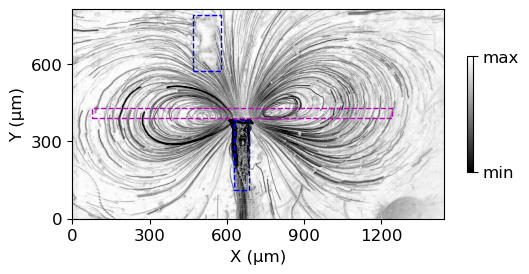

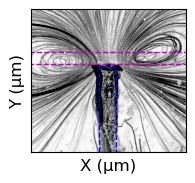

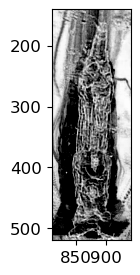

In [5]:
SAVE_FIGURES = False
vmin_ = np.percentile(zproj, 1)#-70 #np.min(zproj)
vmax_ = 0
print(np.min(zproj), np.max(zproj), np.percentile(zproj, [1,5,95]))

# R and D bbox
rotifer_bbox = [835, 910, 150, 510]
detritus_bbox = [625, 770, 760, 1050]
point_count_bbox = [100, img_width-100, 520, 570]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
plot_bbox(detritus_bbox, "blue", ax=ax)
plot_bbox(rotifer_bbox, "blue", ax=ax)
plot_bbox(point_count_bbox, "m", ax=ax)
ax.set(**ax_params); ax.invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale_num_process_frames{process_frames[-1]}.jpg", **fig_params) if SAVE_FIGURES else None


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
plot_bbox(rotifer_bbox, "blue", ax=ax)
plot_bbox(point_count_bbox, "m", ax=ax)
ax.set(**ax_params); ax.invert_yaxis();
ax.set(xlim=(550,1200), ylim=(150, 750), xticks=[], yticks=[]);
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-zoomin.jpg", **fig_params) if SAVE_FIGURES else None

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
ax.set(xlim=(810,940), ylim=(140, 520)); ax.invert_yaxis();


# Locate features
- on feature level exclude around rot (tight) and the obsticle

n features -  579


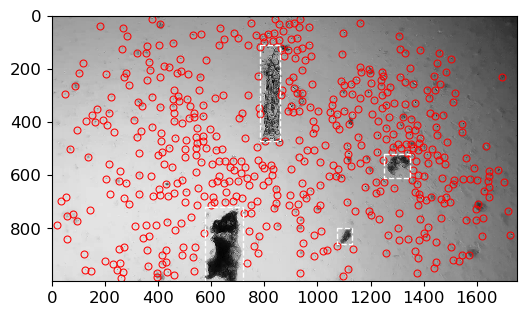

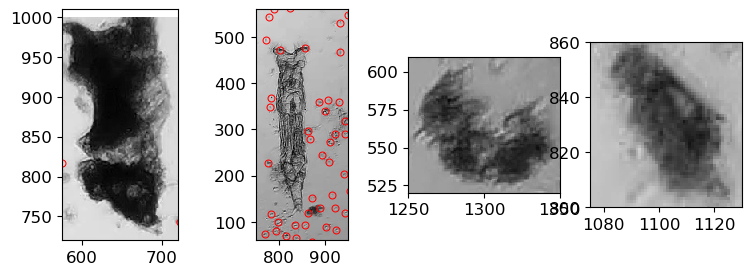

In [6]:
locate_params = {
    "diameter" : 15,
    "threshold" : 5,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [835-xmin, 910-xmin, 150-ymin, 510-ymin]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = {"0" : [625-xmin, 770-xmin, 760-ymin, 1050-ymin],
                 "1" :[1250, 1350, 520, 610],
                 "2" : [1075, 1130, 800, 860]}

for k, dbox in detritus_bbox.items():
    detritus_condition = (f.x > dbox[0]) & (f.x < dbox[1]) & (f.y > dbox[2]) & (f.y < dbox[3])
    f = f[~detritus_condition]

#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# BBoxes to exclude
plot_bbox(rotifer_bbox)
for k, dbox in detritus_bbox.items(): plot_bbox(dbox)

fig, ax = plt.subplots(1,4,figsize=(9,3))
tp.annotate(f, frames[frame_nr], ax=ax[0], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[0].set(xlim=(625-xmin,770-xmin), ylim=(760-ymin, 1050-ymin));

tp.annotate(f, frames[frame_nr], ax=ax[1], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[1].set(xlim=(800-xmin,1000-xmin), ylim=(100-ymin, 600-ymin));

tp.annotate(f, frames[frame_nr], ax=ax[2], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[2].set(xlim=(1250,1350), ylim=(520, 610));

tp.annotate(f, frames[frame_nr], ax=ax[3], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[3].set(xlim=(1075,1130), ylim=(800, 860));

# 2. Batch Process frames

In [8]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)  # fbatch = tp.batch(frames[:3000], **locate_params)  # :3000 takes ca. 10min


rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]

# tmp = []
# for k, dbox in detritus_bbox.items():
#     detritus_condition = (fbatch.x > dbox[0]) & (fbatch.x < dbox[1]) & (fbatch.y > dbox[2]) & (fbatch.y < dbox[3])
#     tmp.append(detritus_condition)

# detritus_idx = pd.DataFrame(tmp).any().to_numpy(); del tmp
# fbatch = fbatch[~detritus_idx]
    
detritus_condition = (fbatch.x > detritus_bbox["0"][0]) & (fbatch.x < detritus_bbox["0"][1]) & (fbatch.y > detritus_bbox["0"][2]) & (fbatch.y < detritus_bbox["0"][3])
fbatch = fbatch[~detritus_condition]
print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

SAVE_FBATCH = False
fbatch.to_csv(f"{save_figure_path}/fbatch_3000_frames.csv", index=False) if SAVE_FBATCH else None

fbatch

rotifer 111613 
detrituts 110676


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.634872,375.609231,338.208403,2.839827,0.575493,18.384662,-18251.2831,0.763676,0
1,13.588439,932.850289,600.103116,3.536515,0.378863,15.609619,-15483.9350,0.308624,0
2,14.161290,887.954701,505.404763,3.488091,0.315508,19.772184,-15891.9628,0.338350,0
3,13.892857,840.540344,524.483186,3.846509,0.406942,21.159705,-16942.7549,0.449965,0
4,27.352188,748.266809,325.026948,2.051628,0.450944,23.587868,-17921.3643,0.649504,0
...,...,...,...,...,...,...,...,...,...
2031726,957.802780,464.433536,402.296426,1.929694,0.204425,27.612005,-24905.4708,-0.303058,3310
2031728,959.868679,1528.463295,428.510355,1.992441,0.289344,30.757676,-15211.1464,0.288307,3310
2031730,964.556059,395.870895,617.250641,3.702712,0.365664,17.126433,-22442.3722,-0.632889,3310
2031731,978.162256,1097.905989,501.909355,3.287098,0.127991,22.019700,-21057.3698,-1.631062,3310


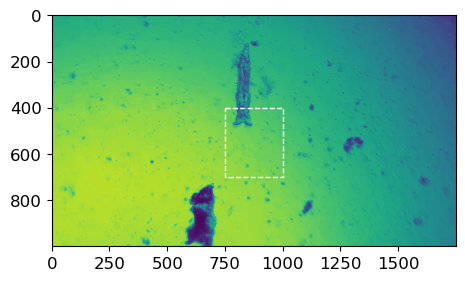

In [9]:
zoom_in = [750, 1000, 400, 700] 

plt.figure()
plt.imshow(frames[0])
plot_bbox(zoom_in)

# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

# 3. Link particles / frames to trajectories

In [10]:
link_params = {
    "search_range" : 25,  # 40, within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 34705
30
N Before: 34705 
 N after filtering: 6308


# 4. Visualize Trajectories

In [11]:
#SAVE_TRAJS = False
#LOAD_TRAJS = True
#trajs.to_csv(f"{save_figure_path}/trajs_3000_frames.csv", index=False) if SAVE_TRAJS else None
#trajs = pd.read_csv(f"{save_figure_path}/trajs_3000_frames.csv") if LOAD_TRAJS else None

#fig, ax = plt.subplots()
#tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax); #ax.set(**ax_params); 

# fig, ax = plt.subplots()
# tp.scatter(trajs, ax=ax, plot_style={"ms" : 1, "alpha" : .1, "color" : "k"});
# ax.set(**ax_params); ax.invert_yaxis();

### further filtering

number of particles = number of trajectories: 6308
number of particles (original): 6308 
number of particles remaining: 1509
number of particles = number of trajectories: 1509


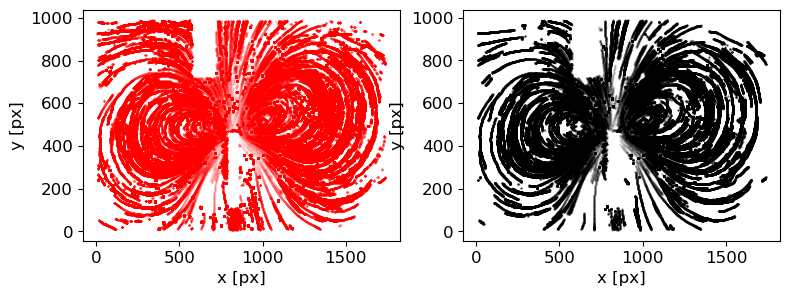

In [12]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 4.5) | (stats.y_std < 4.5)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

fig, ax = plt.subplots(1,2,figsize=(9,3))
tp.scatter(trajs, ax=ax[0], plot_style={"ms" : .25, "alpha" : .1, "color" : "r"}); ax[0].invert_yaxis(); 
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : .5, "alpha" : .1, "color" : "k"}); ax[1].invert_yaxis();

In [13]:
# check for velocit jumps!
df = ctraj[["x", "y", "particle", "frame"]].copy()
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)# * fps / mpp
df["v"] = df["v"].mask(df["v"]>=24)
df = df.dropna(subset="v")

In [14]:
# loop acrss trajectories and remove the ones that have any over a threshold (adjust for maybe less than 10% under trheshold or something)
particles = df.particle.unique()
keep_parts = []
for prt in particles:
    acc = df.groupby("particle").get_group(prt)["v"].diff().diff()
    if not np.any((acc <= -7.5) | (acc > 7.5)):
        keep_parts.append(prt)

print(len(keep_parts)) # 585

575


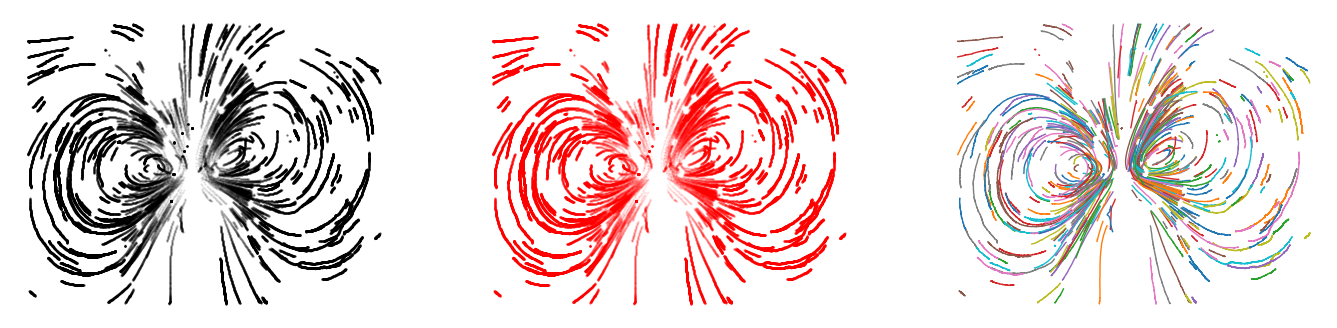

In [15]:
keeptrajs = ctraj[ctraj.particle.isin(keep_parts)]
keeptrajs_ = df[df.particle.isin(keep_parts)]

fig, ax = plt.subplots(1,3,figsize=(17,4))
tp.scatter(keeptrajs, ax=ax[0], plot_style={"ms" : .5, "alpha" : .1, "color" : "k"}); ax[0].invert_yaxis();ax[0].set_axis_off()
tp.scatter(keeptrajs_, ax=ax[1], plot_style={"ms" : .5, "alpha" : .1, "color" : "r"}); ax[1].invert_yaxis();ax[1].set_axis_off()
tp.plot_traj(keeptrajs_, ax=ax[2]); ax[2].invert_yaxis();ax[2].set_axis_off()

[(0.0, 1220000.0)]

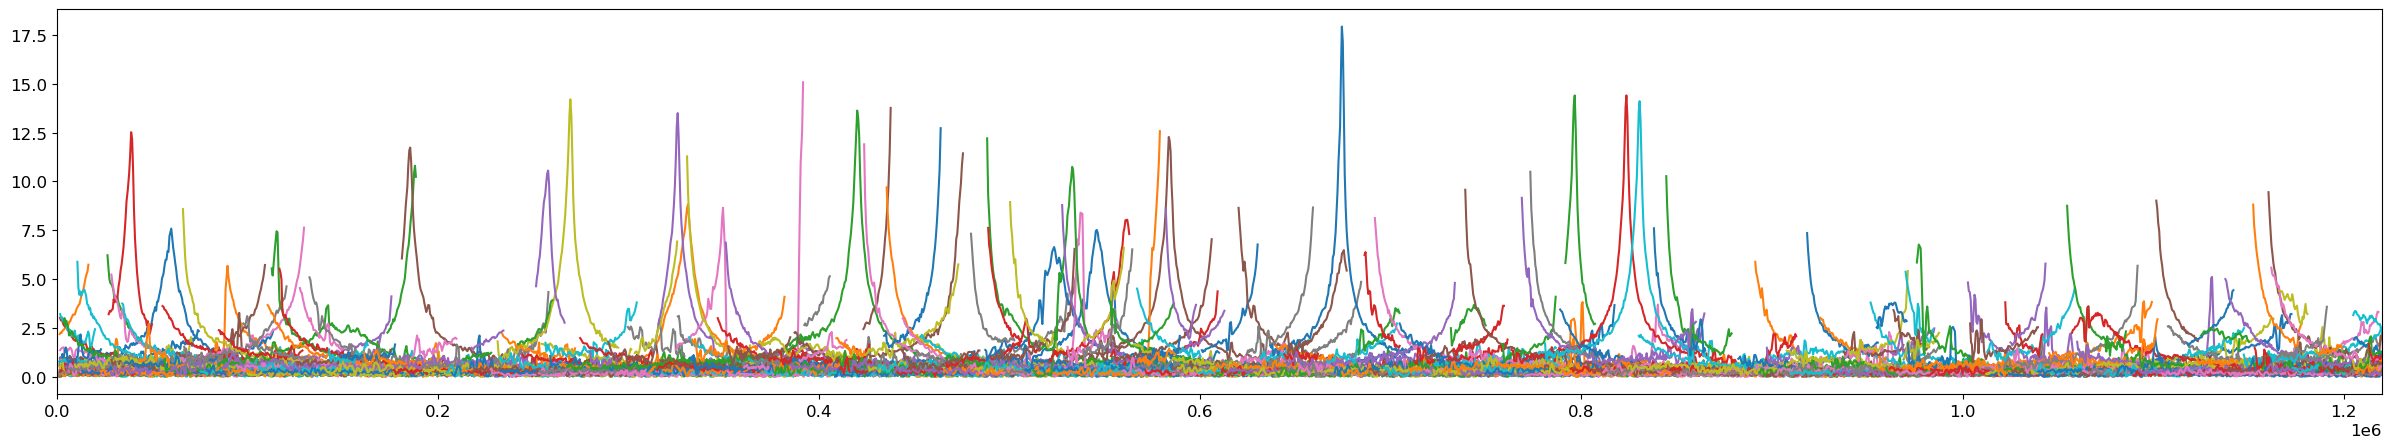

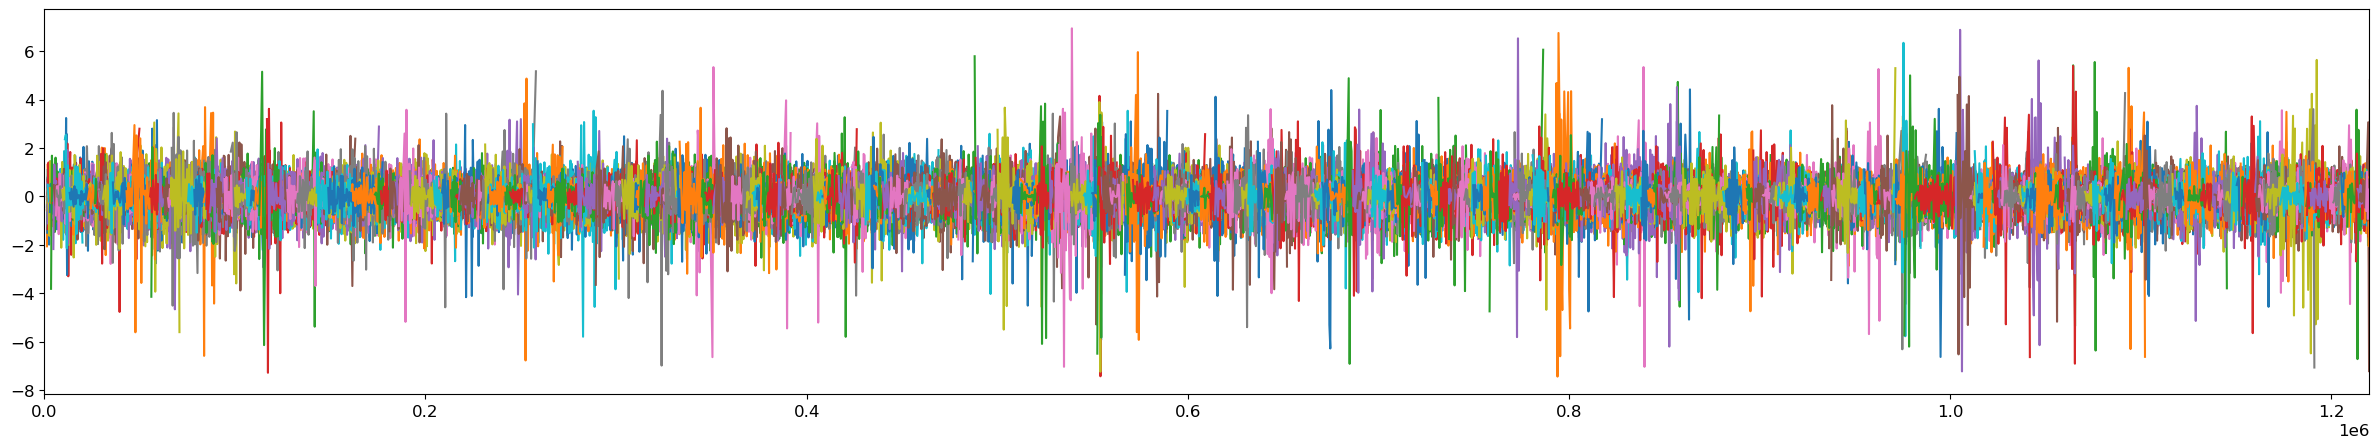

In [16]:
fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts:
    plt.plot(df.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())
ax.set(xlim=(0, 1220000))

fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts:
    plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff())#.rolling(window=2).mean())

ax.set(xlim=(0, 1220000))

In [17]:

# fig,ax = plt.subplots(figsize=(30,5))
# show_prts = 35
# particles = df.particle.unique()
# # keep_parts = []
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff(), "-", color="lightgrey")
#     # if not np.any(df.groupby("particle").get_group(prt)["v"].diff().diff()>=15):
#     #     keep_parts.append(prt)
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff().rolling(window=3).mean())
# ax.set(xlim=(0, 1220000/3))

# fig,ax = plt.subplots(figsize=(30,5))
# #plt.hlines(10, xmin=0, xmax=30000)
# particles = df.particle.unique()
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"], "-", color="lightgrey")
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].rolling(window=4).mean())

# ax.set(xlim=(0, 1220000/3))


In [18]:
points = keeptrajs_[["x", "y"]].where(keeptrajs_["v"].notna()).to_numpy()
v_xy = keeptrajs_["v"].where(keeptrajs_["v"].notna()).to_numpy()
dxy = keeptrajs_[["dx", "dy"]].where(keeptrajs_["v"].notna()).to_numpy()
print(v_xy.shape, points.shape, sum(np.isnan(dxy)), sum(np.isnan(points)))
points

(229693,) (229693, 2) [0 0] [0 0]


array([[1011.00648649,  637.12702703],
       [ 572.81233933,  677.02827763],
       [ 220.1487069 ,  669.18103448],
       ...,
       [1577.00977517,  373.41446725],
       [ 472.47569721,  357.60876494],
       [1600.33892886,  353.02478018]])

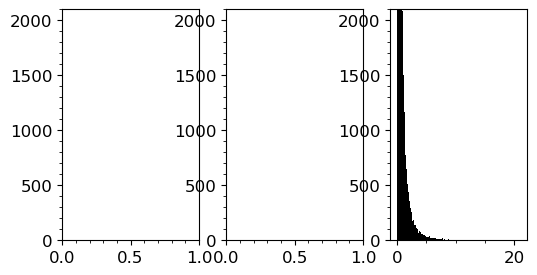

In [19]:
# check and remove rapid velocity changes
#d_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2)
d_xy = argnotnan(keeptrajs_.v.to_numpy())
#cx, xbins_ = np.histogram(velocities[:,0], bins=300)
#cy, ybins_ = np.histogram(velocities[:,1], bins=300)
cxy, xybins_ = np.histogram(d_xy, bins=300)

fig, ax = plt.subplots(1,3)
#ax[0].bar(xbins_[:-1], cx, width=np.diff(xbins_[:2]), color="b")
#ax[1].bar(ybins_[:-1], cy, width=np.diff(ybins_[:2]), color="r")
ax[2].bar(xybins_[:-1], cxy, width=np.diff(xybins_[:2]), color="k")
for cax in ax:
    cax.set(ylim=(0, 2100))
    cax.minorticks_on()

In [1]:
SAVE_FIGURES = False
bin_size_2d = 30 #25
sigma_2d = 1

cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=20)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 95)
ovmax = np.percentile(interpolated_omap, 95)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
plot_bbox(rotifer_bbox, "k", ax=ax[0]); #plot_bbox(detritus_bbox, "k", ax=ax[0])
ax[0].set(**ax_params); #ax[0].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
plot_bbox(rotifer_bbox, "k", ax=ax[1]); #plot_bbox(detritus_bbox, "k", ax=ax[1])
ax[1].set(**ax_params); #ax[1].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

NameError: name 'plt' is not defined

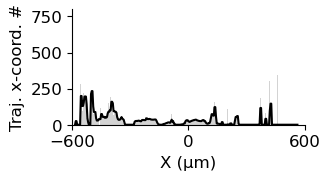

In [21]:
point_count_bbox = [100, img_width-100, 520, 570]

bbox_condition = (keeptrajs_.y >= 520) & (keeptrajs_.y < 571) & (keeptrajs_.x >= 100) & (keeptrajs_.x < img_width-100)
count, bins = np.histogram(keeptrajs_.loc[bbox_condition,"x"].to_numpy(), bins=np.arange(100, img_width-100, 5))

rotifer_cm_x = 890
bins = (bins - rotifer_cm_x) / mpp
df_counts = pd.DataFrame(np.vstack((bins[:-1], count)).T, columns=["bins", "counts"])

fig, ax = plt.subplots(figsize=(3,1.5))
ax.bar(bins[:-1], count, width=np.diff(bins)[1], color="lightgray")
ax.plot(df_counts.bins, df_counts.counts.rolling(window=3).median(), "-k", lw=1.5)
ax.set(ylim=(0, 800), yticks=[0,250,500,750], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600],
       xlabel="X (µm)", ylabel="Traj. x-coord. #")
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-traj-x-coord-histogram.jpg", **fig_params) if SAVE_FIGURES else None

In [22]:
df_filt = pd.DataFrame()

for nth in particles:
    traj = keeptrajs_.loc[keeptrajs_["particle"] == nth]
    traj = traj.loc[bbox_condition]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_filt = pd.concat([df_filt, df_loop[1:]])

# XY Velocity at XY coordinates
velocities = df_filt[["dx", "dy"]].to_numpy()

# Velocity per point
df_filt["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_22963/4178029802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


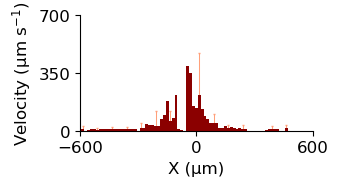

In [23]:
bin_width = 20
bin_edges = np.arange(100, img_width-100, bin_width)
df_filt["x_bin"] = pd.cut(df_filt["x"], bins=bin_edges)
grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_x) / mpp


fig, ax = plt.subplots(figsize=(3,1.5))
plt.errorbar(bin_centers, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=5, capsize=1, zorder=1)
plt.bar(bin_centers, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 700), yticks=[0,350,700], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600],
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)")

ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram.jpg", **fig_params) if SAVE_FIGURES else None


3.2586219780733072e-06 0.9518346740192747


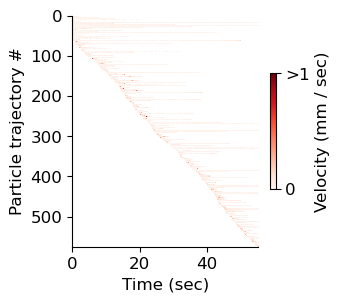

In [24]:
full_frames = np.arange(num_frames)
displacement_array = reindex_calculate_displacement_and_stack(keeptrajs_, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
displacement_array[displacement_array==0.0] = np.nan

fr_time = np.arange(num_frames) / fps
print(np.nanmin(displacement_array), np.nanmax(displacement_array))

fig, ax = plt.subplots(1, 1, figsize=(3,3))
cax = ax.imshow(displacement_array, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=1, extent=[0, fr_time[-1], displacement_array.shape[0], 0])
ax.set(xlabel="Time (sec)", ylabel="Particle trajectory #")
cbar = fig.colorbar(cax, label="Velocity (mm / sec)", shrink=.5); cbar.ax.set(yticks=(0,1), yticklabels=["0", ">1"]);
ax.spines[["top","right"]].set_visible(False)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_trajectories-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

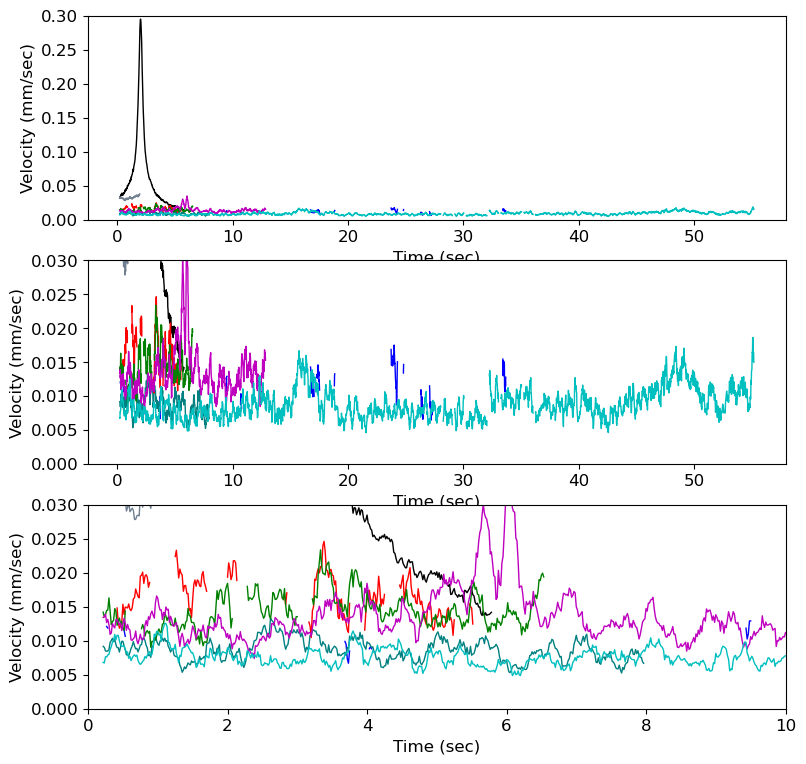

In [25]:
displacement_array = reindex_calculate_displacement_and_stack(keeptrajs_, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

selected_indices = np.arange(8)
prt_colors = ["k", "slategrey", "b", "teal", "r", "g", "m", "c", "b"]

rwindow=12
fig, ax = plt.subplots(3,1,figsize=(9,9))
for cax in ax:
    for pc, sidx in zip(prt_colors, selected_indices):
        cax.plot(fr_time, df_disp.iloc[:,sidx].rolling(window=rwindow).mean(), lw=1, color=pc, label=f"prt {sidx}");

xylim = {0 : {"ylim" : (0, .3)},
         1 : {"ylim" : (0, .03)},
         2 : {"ylim" : (0, .03), "xlim" : (0, 10)}}

for nth, cax in enumerate(ax):
    cax.set(xlabel="Time (sec)", ylabel="Velocity (mm/sec)", **xylim[nth])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-velocity-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

# Velocity field calculation

In [26]:
# Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 15), np.arange(0, img_height, 15))

# Interpolate velocities onto grid
#grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
#grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')
grid_u = griddata(points, dxy[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, dxy[:, 1], (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

-0.4878804758346137 0.4909440836406345


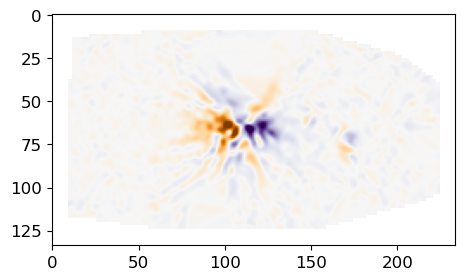

In [27]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=1)

plt.figure()
plt.imshow(vort_map, vmin=-.25,vmax=.25, cmap="PuOr", alpha=1)

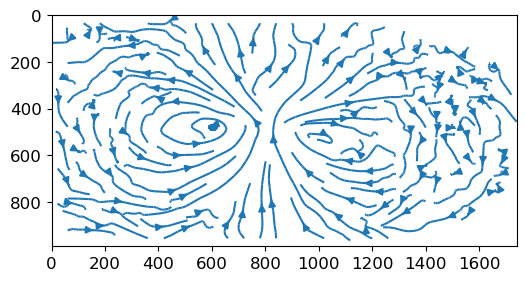

In [28]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v)
plt.gca().invert_yaxis()

In [ ]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

print(len(is_continuous))

fig, ax = plt.subplots(1,1)
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        tp.plot_traj(traj, ax=ax, plot_style={"lw" : 1, "alpha" : .6, "color" : "k"})

In [ ]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 20)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

#ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

### trajectory params

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");